In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import h5py

import shutil
from keras.models import load_model
from keras import layers
from keras import models
from keras import optimizers

In [2]:
print(tf.__version__)

2.8.3


In [3]:
# set params
batch_size = 32
img_height = 100
img_width = 100

In [4]:
# image_count = 86782 # this number should be extracted from xBD_data_processing.ipynb
# data_dir = './xBD_Dataset/building_crops/'
# list_ds = tf.data.Dataset.list_files((data_dir + '*/*'), shuffle=False)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
data_dir = './xBD_Dataset/building_crops/'
damaged_ds = tf.data.Dataset.list_files((data_dir + 'damaged/*'), shuffle=False)
l1 = len(damaged_ds)
print("Total number of available images in class 'damaged' is:", l1)
undamaged_ds = tf.data.Dataset.list_files((data_dir + 'undamaged/*'), shuffle=False)
l2 = len(undamaged_ds)
print("Total number of available images in class 'undamaged' is:", l2)

Total number of available images in class 'damaged' is: 14006
Total number of available images in class 'undamaged' is: 72776


In [6]:
undamaged_ds = undamaged_ds.shuffle(l1, seed = 207).take(l1)
image_count = l1*2
list_ds = undamaged_ds.concatenate(damaged_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
# print("Total number of combined images after undersampling majority class is:", len(list_ds))

In [7]:
for f in list_ds.take(10):
    print(f.numpy())

b'.\\xBD_Dataset\\building_crops\\damaged\\santa-rosa-wildfire-13402-damaged.png'
b'.\\xBD_Dataset\\building_crops\\damaged\\santa-rosa-wildfire-14431-damaged.png'
b'.\\xBD_Dataset\\building_crops\\damaged\\joplin-tornado-5251-damaged.png'
b'.\\xBD_Dataset\\building_crops\\damaged\\santa-rosa-wildfire-4851-damaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\moore-tornado-15670-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\joplin-tornado-4586-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\portugal-wildfire-12578-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\moore-tornado-9749-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\moore-tornado-12557-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\moore-tornado-13597-undamaged.png'


In [8]:
class_names = np.array(sorted([item for item in os.listdir(data_dir)],reverse=True))
print(class_names)

['undamaged' 'damaged']


In [9]:
val_size = int(image_count * 0.1)
test_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size + test_size)
val_ds = list_ds.take(val_size + test_size)

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

In [10]:
# tensorflow tutorial functions for manual creation of datasets
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # (FORMAT = PNG) convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size (WITH PAD)
    return tf.image.resize_with_pad(img, 100, 100)

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (100, 100, 3)
Label:  0


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

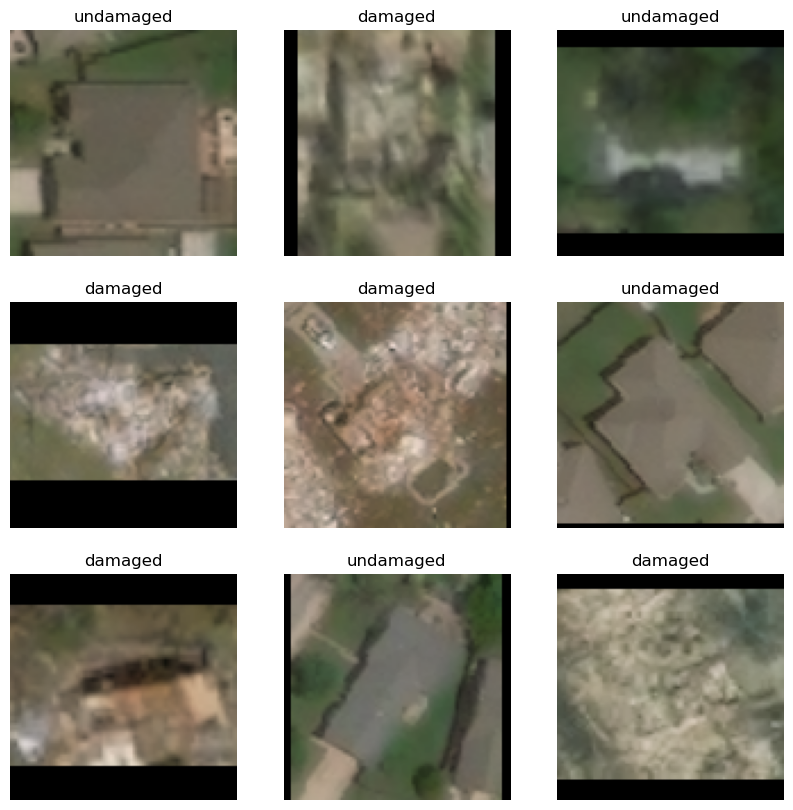

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

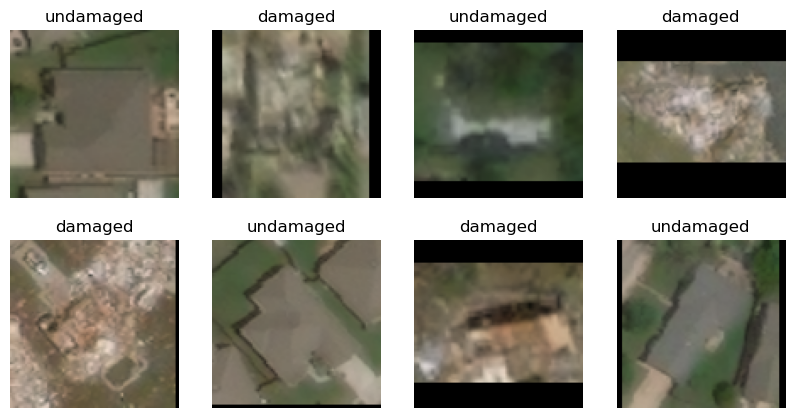

In [21]:
plt.figure(figsize=(10, 5))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [15]:
from keras import optimizers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
])

#try again with Adam optimizer
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape = (100,100,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                 metrics = [tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

#fit the model from image generator
history = model.fit(
            train_ds,
            epochs=100,
            validation_data=val_ds)

Epoch 1/100
701/701 [==============================] - 13s 15ms/step - loss: 0.4349 - precision: 0.8005 - recall: 0.7926 - accuracy: 0.7985 - val_loss: 0.2261 - val_precision: 0.8613 - val_recall: 0.9685 - val_accuracy: 0.9043
Epoch 2/100
701/701 [==============================] - 8s 12ms/step - loss: 0.2289 - precision: 0.9162 - recall: 0.9079 - accuracy: 0.9129 - val_loss: 0.1450 - val_precision: 0.9586 - val_recall: 0.9238 - val_accuracy: 0.9407
Epoch 3/100
701/701 [==============================] - 8s 11ms/step - loss: 0.1965 - precision: 0.9313 - recall: 0.9164 - accuracy: 0.9248 - val_loss: 0.1328 - val_precision: 0.9501 - val_recall: 0.9462 - val_accuracy: 0.9472
Epoch 4/100
701/701 [==============================] - 7s 11ms/step - loss: 0.1809 - precision: 0.9375 - recall: 0.9244 - accuracy: 0.9317 - val_loss: 0.1584 - val_precision: 0.9198 - val_recall: 0.9699 - val_accuracy: 0.9414
Epoch 5/100
701/701 [==============================] - 7s 10ms/step - loss: 0.1745 - precision:

701/701 [==============================] - 8s 11ms/step - loss: 0.1264 - precision: 0.9556 - recall: 0.9448 - accuracy: 0.9507 - val_loss: 0.1078 - val_precision: 0.9560 - val_recall: 0.9566 - val_accuracy: 0.9554
Epoch 38/100
701/701 [==============================] - 8s 11ms/step - loss: 0.1269 - precision: 0.9582 - recall: 0.9451 - accuracy: 0.9522 - val_loss: 0.1527 - val_precision: 0.9104 - val_recall: 0.9734 - val_accuracy: 0.9375
Epoch 39/100
701/701 [==============================] - 7s 11ms/step - loss: 0.1296 - precision: 0.9582 - recall: 0.9416 - accuracy: 0.9505 - val_loss: 0.1150 - val_precision: 0.9794 - val_recall: 0.9329 - val_accuracy: 0.9557
Epoch 40/100
701/701 [==============================] - 8s 11ms/step - loss: 0.1264 - precision: 0.9582 - recall: 0.9443 - accuracy: 0.9518 - val_loss: 0.1127 - val_precision: 0.9510 - val_recall: 0.9636 - val_accuracy: 0.9561
Epoch 41/100
701/701 [==============================] - 8s 11ms/step - loss: 0.1267 - precision: 0.9572 -

701/701 [==============================] - 7s 10ms/step - loss: 0.1207 - precision: 0.9600 - recall: 0.9487 - accuracy: 0.9548 - val_loss: 0.1182 - val_precision: 0.9450 - val_recall: 0.9741 - val_accuracy: 0.9579
Epoch 74/100
701/701 [==============================] - 7s 10ms/step - loss: 0.1193 - precision: 0.9607 - recall: 0.9477 - accuracy: 0.9547 - val_loss: 0.0966 - val_precision: 0.9677 - val_recall: 0.9622 - val_accuracy: 0.9643
Epoch 75/100
701/701 [==============================] - 7s 10ms/step - loss: 0.1161 - precision: 0.9616 - recall: 0.9490 - accuracy: 0.9557 - val_loss: 0.1048 - val_precision: 0.9609 - val_recall: 0.9636 - val_accuracy: 0.9614
Epoch 76/100
701/701 [==============================] - 7s 10ms/step - loss: 0.1199 - precision: 0.9603 - recall: 0.9478 - accuracy: 0.9545 - val_loss: 0.1035 - val_precision: 0.9788 - val_recall: 0.9385 - val_accuracy: 0.9582
Epoch 77/100
701/701 [==============================] - 8s 11ms/step - loss: 0.1176 - precision: 0.9614 -

In [16]:
model.summary()

NameError: name 'model' is not defined

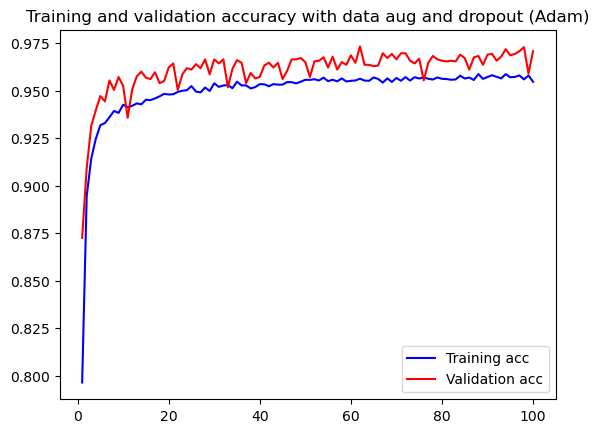

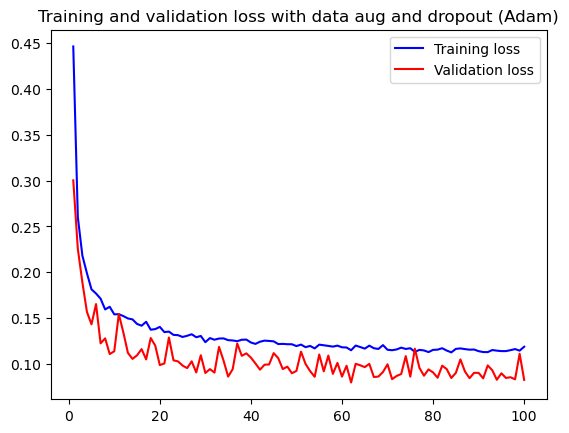

In [21]:
#plot loss and accuracy for detection overfitting
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()

plt.show()

In [22]:
model.save('cc_model_with_dropout_2.h5')

In [141]:
from keras.preprocessing import image
# img_path = './xBD_Dataset/building_crops/damaged/joplin-tornado-8996-damaged.png'
img_path = './xBD_Dataset/building_crops/undamaged/joplin-tornado-560-undamaged.png'

img = image.load_img(img_path, target_size = (100,100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 100, 100, 3)


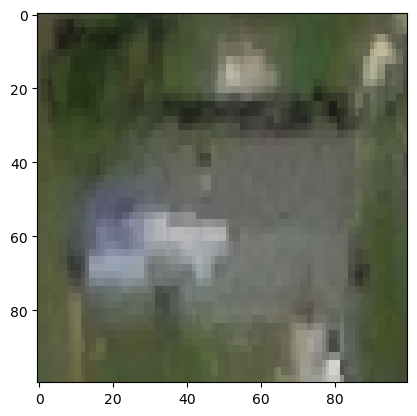

In [142]:
plt.imshow(img_tensor[0])
plt.show()

In [143]:
layer_outputs = [layer.output for layer in model.layers[2:]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [144]:
activations = activation_model.predict(img_tensor)

(1, 98, 98, 32)


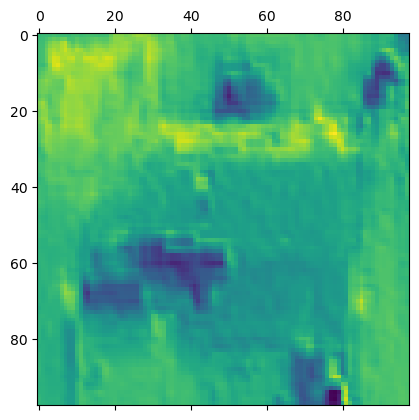

In [145]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0,:,:,2]*255,cmap = 'viridis');

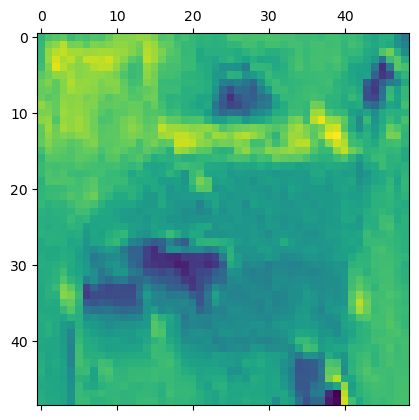

In [146]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0,:,:,2]*255,cmap = 'viridis');

D:\temp\ipykernel_25480\1119252562.py:15: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
D:\temp\ipykernel_25480\1119252562.py:18: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


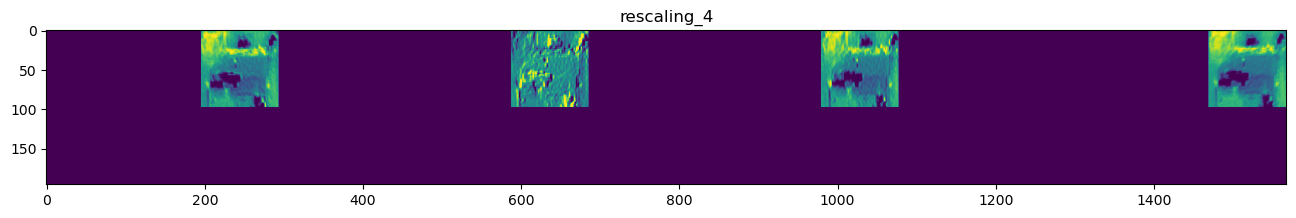

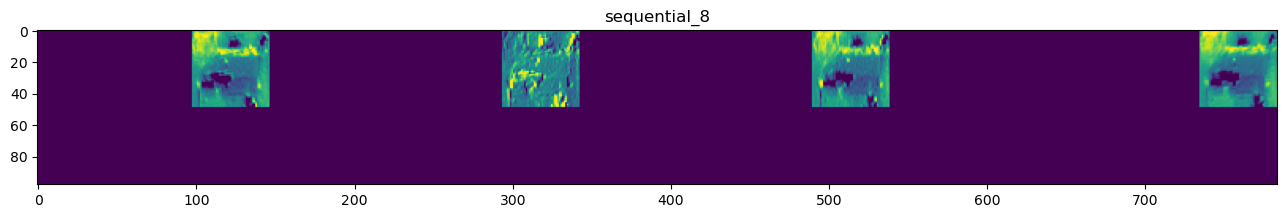

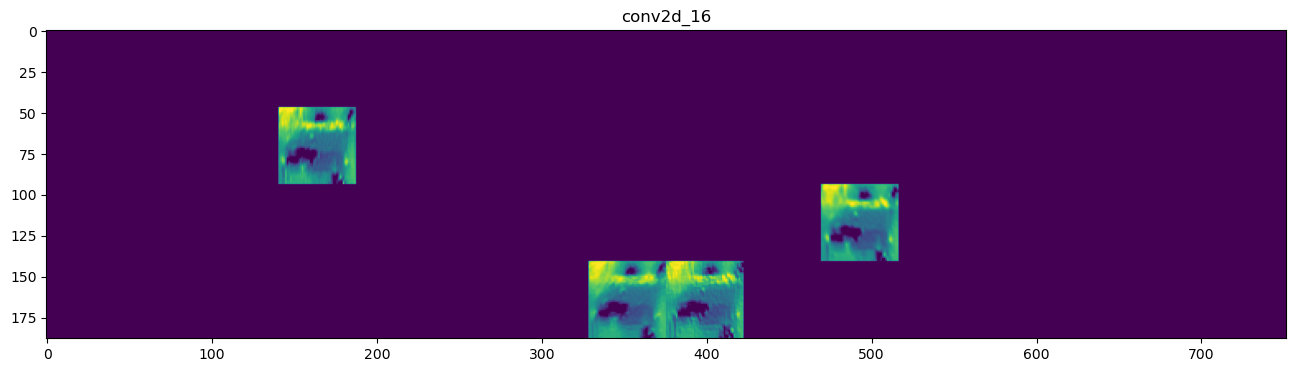

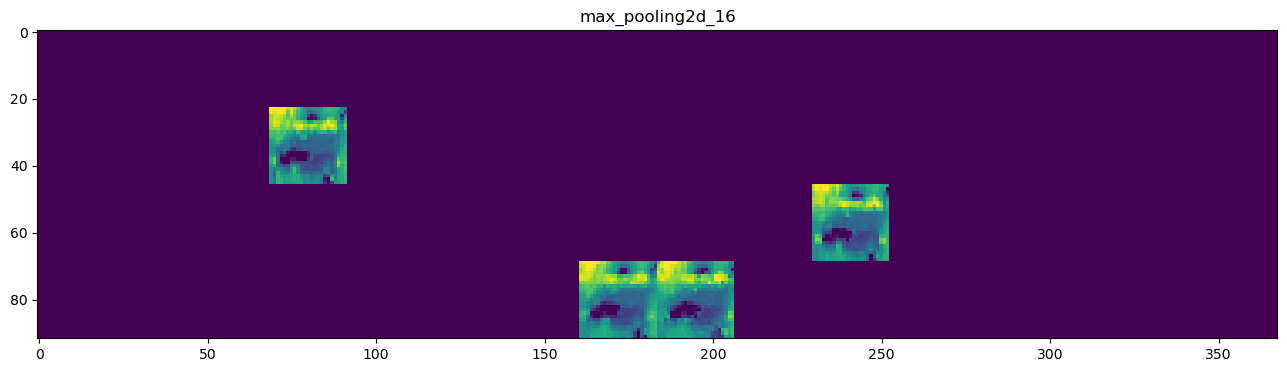

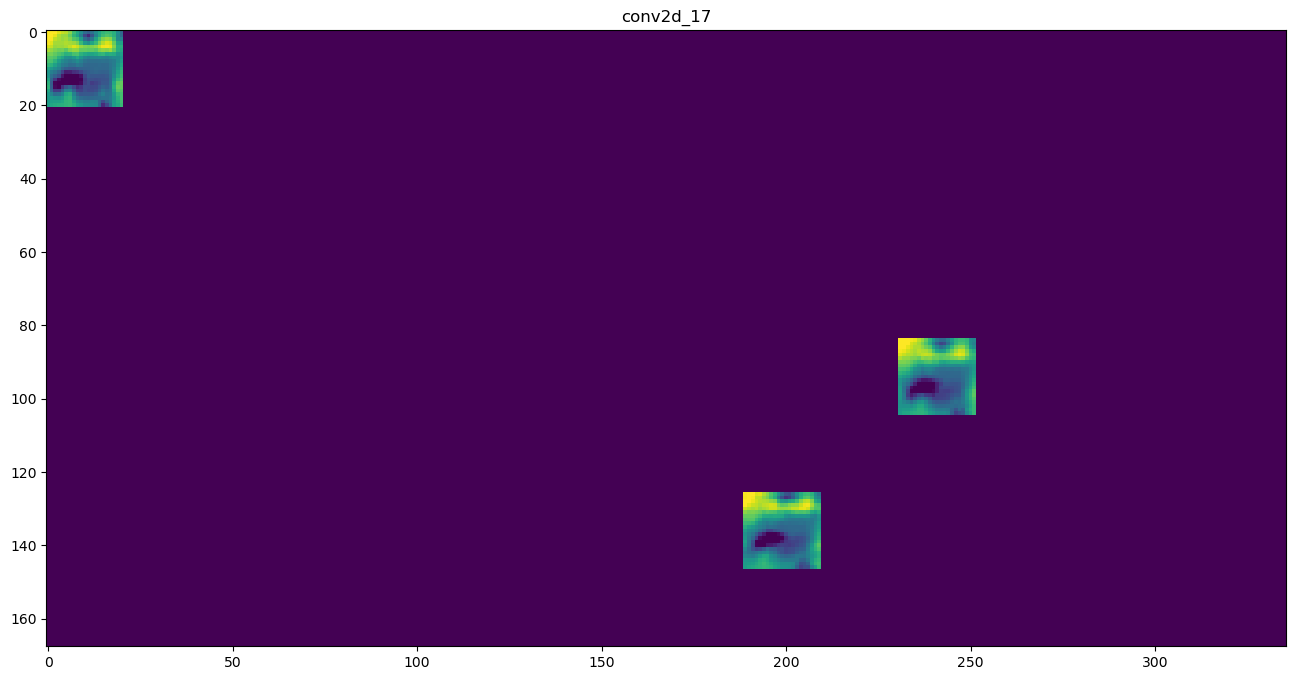

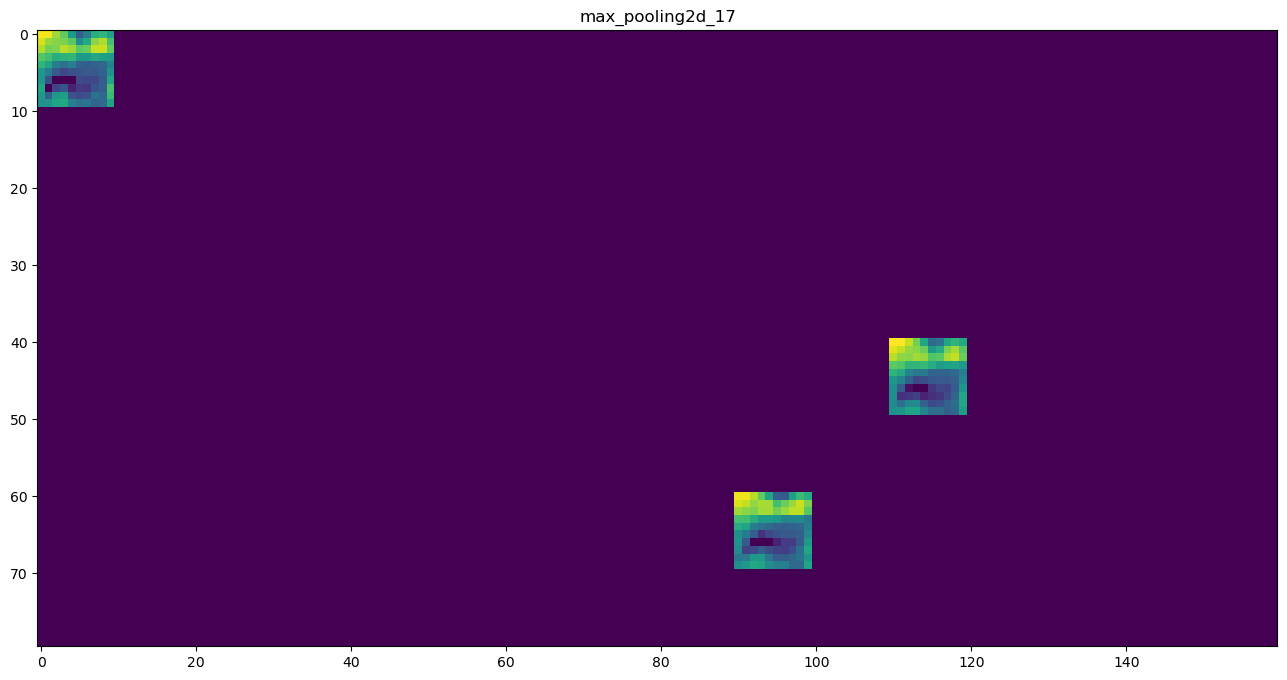

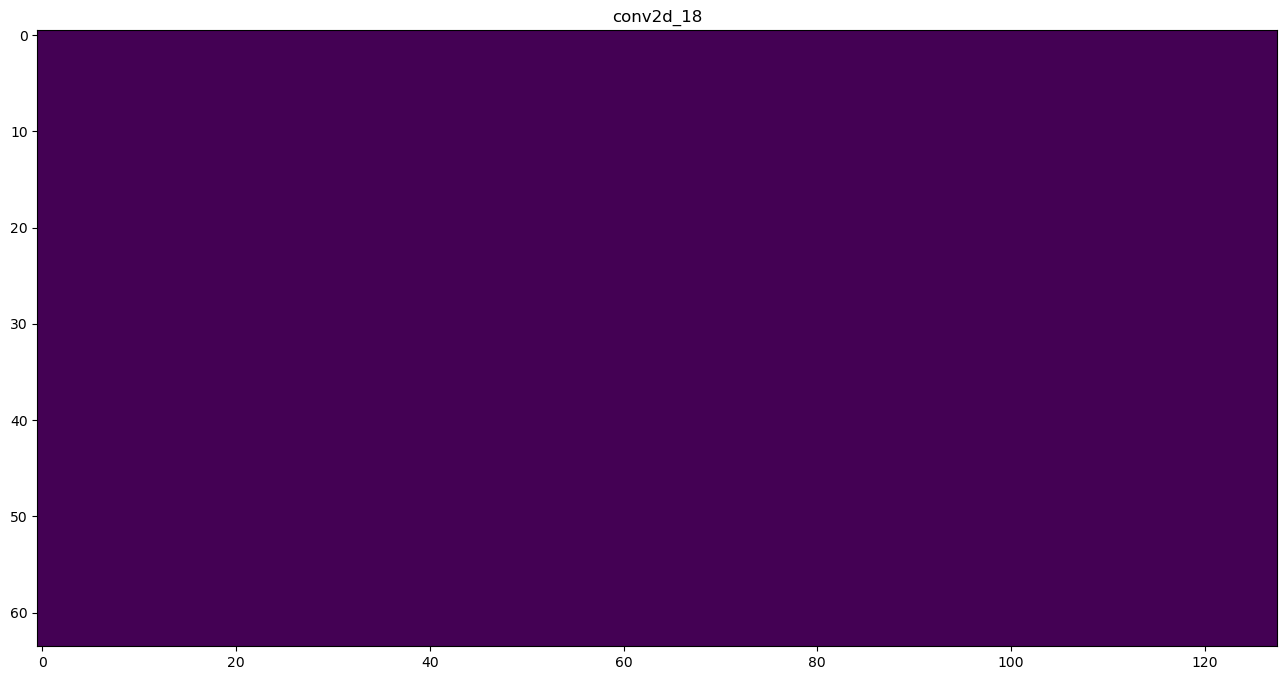

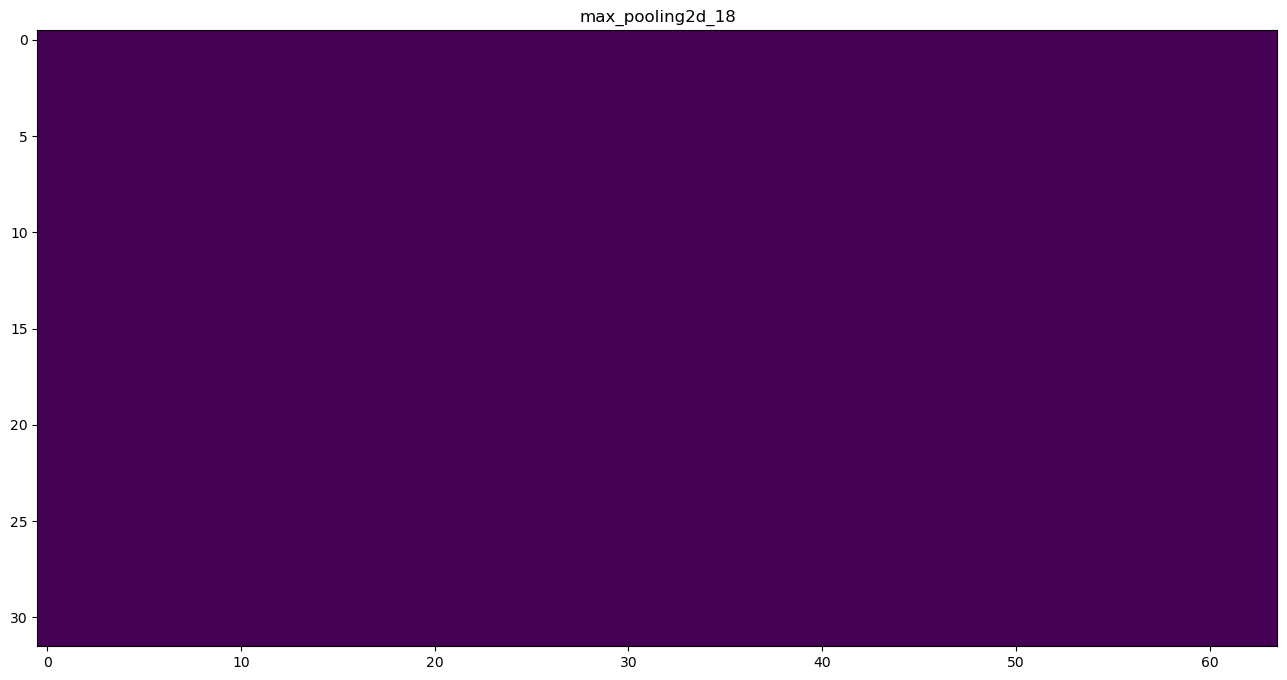

In [147]:
layer_names =[]
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size,row*size:(row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')